# Look at the data 

In [69]:
import csv
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [ ]:
filename = 'train.csv' 
df = pd.read_csv(filename)
df.head()

# Preprocess the Data

## Fix Null Field Positions

In [64]:
field_positions = df['FieldPosition']
print(sum(field_positions.isnull()==True))
print(df.shape)

6424
(509762, 49)


In [65]:
# Handle 50 YardLine by filling in the null 'FieldPositions' with the value in 'PossessionTeam'
print(df[df.FieldPosition.isnull()][['GameId', 'PlayId', 'FieldPosition', 'PossessionTeam', 'YardLine']].head())
df.FieldPosition.fillna(df.PossessionTeam, inplace=True)
print(df[198:203][['GameId', 'PlayId', 'FieldPosition', 'PossessionTeam', 'YardLine']])

field_positions = df['FieldPosition']
print(sum(field_positions.isnull()==True))
print(df.shape)

         GameId          PlayId FieldPosition PossessionTeam  YardLine
198  2017090700  20170907000801           NaN             KC        50
199  2017090700  20170907000801           NaN             KC        50
200  2017090700  20170907000801           NaN             KC        50
201  2017090700  20170907000801           NaN             KC        50
202  2017090700  20170907000801           NaN             KC        50
         GameId          PlayId FieldPosition PossessionTeam  YardLine
198  2017090700  20170907000801            KC             KC        50
199  2017090700  20170907000801            KC             KC        50
200  2017090700  20170907000801            KC             KC        50
201  2017090700  20170907000801            KC             KC        50
202  2017090700  20170907000801            KC             KC        50
0
(509762, 49)


## Downsample, keep only entries where players is rusher

In [66]:
# Same gameid, same playid, same yards gained for the first 5 entries... hm..
print(df.head()[['GameId', 'PlayId', 'FieldPosition', 'PossessionTeam', 'YardLine', 'Yards']])
print(df.shape)

       GameId          PlayId FieldPosition PossessionTeam  YardLine  Yards
0  2017090700  20170907000118            NE             NE        35      8
1  2017090700  20170907000118            NE             NE        35      8
2  2017090700  20170907000118            NE             NE        35      8
3  2017090700  20170907000118            NE             NE        35      8
4  2017090700  20170907000118            NE             NE        35      8
(509762, 49)


In [67]:
df = df[df['NflIdRusher']==df['NflId']] # only keep entries associated with the rusher
df.reset_index(drop=True, inplace=True)
print(df.head()[['GameId', 'PlayId', 'FieldPosition', 'PossessionTeam', 'YardLine', 'Yards']])
print(df.shape)

       GameId          PlayId FieldPosition PossessionTeam  YardLine  Yards
0  2017090700  20170907000118            NE             NE        35      8
1  2017090700  20170907000139            NE             NE        43      3
2  2017090700  20170907000189            KC             NE        35      5
3  2017090700  20170907000345            KC             NE         2      2
4  2017090700  20170907000395            KC             KC        25      7
(23171, 49)


## Calculate number of yards remaining 

In [68]:
df['YardsRemaining'] = 100 - df.YardLine[df.FieldPosition == df.PossessionTeam]
df.YardsRemaining.fillna(df.YardLine, inplace=True)
df.head()[['GameId', 'PlayId', 'FieldPosition', 'PossessionTeam', 'YardLine', 'Yards', 'YardsRemaining']]

,GameId,PlayId,FieldPosition,PossessionTeam,YardLine,Yards,YardsRemaining
0,2017090700,20170907000118,NE,NE,35,8,65.0
1,2017090700,20170907000139,NE,NE,43,3,57.0
2,2017090700,20170907000189,KC,NE,35,5,35.0
3,2017090700,20170907000345,KC,NE,2,2,2.0
4,2017090700,20170907000395,KC,KC,25,7,75.0


# Train and Dev Split

In [71]:
train, dev = train_test_split(df, test_size=0.3, random_state=1, shuffle=True)

In [74]:
print(train.shape)
print(dev.shape)

(16219, 50)
(6952, 50)


# Perform Naive Bayes 

## Calculate probability of yards gained squashed with yards remaining

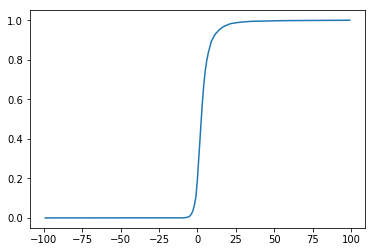

In [93]:
# calculate pmf 
yard_counts = np.zeros((199), dtype = 'double')
for yard in range(-99, 100):
    yard_counts[yard+99] = sum(train['Yards']==yard)
yard_probabilities = yard_counts / np.sum(yard_counts)

# calculate cdf
yard_cdf = np.cumsum(yard_probabilities)

plt.plot(np.arange(-99,100), yard_cdf)

## Squashing probabilities 

In [97]:
# squash probabilities
def squash(yard_cdf, yard_remaining):
    squash_cdf = yard_cdf.copy()
    squash_cdf[199-(100 - yard_remaining):] = 1
    squash_cdf[0:yard_remaining-1] = 0 
    return squash_cdf

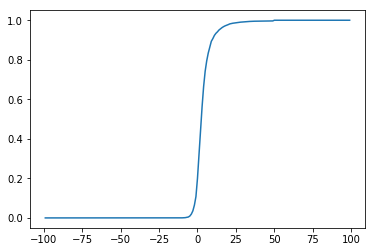

In [103]:
squash_cdf = squash(yard_cdf, 50)
plt.plot(np.arange(-99,100), squash_cdf)

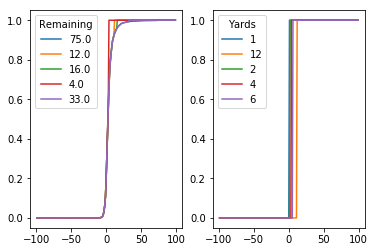

In [131]:
fig, axes = plt.subplots(1, 2)
for index, row in dev.head().iterrows():
    pred_cdf = squash(yard_cdf, int(row['YardsRemaining']))
    axes[0].plot(np.arange(-99,100), pred_cdf, label=row['YardsRemaining'])
    true_cdf = np.zeros(199)
    true_cdf[99+row['Yards']:] = 1
    axes[1].plot(np.arange(-99,100), true_cdf, label=row['Yards'])
    (pred_cdf-true_cdf)**2

axes[0].legend(title='Remaining')
axes[1].legend(title='Yards')

## Loss for model using all of the data

In [136]:
all_loss = []
for index, row in dev.iterrows():
    pred_cdf = squash(yard_cdf, int(row['YardsRemaining']))
    true_cdf = np.zeros(199)
    true_cdf[99+row['Yards']:] = 1
    loss = 1/199 * np.sum((pred_cdf-true_cdf)**2)
    all_loss.append(loss)
cost = np.average(all_loss)
print("Cost: {}".format(cost))

Cost: 0.014044054093647522


## Using a model for each yard line

In [146]:
yard_counts = np.zeros((99,199), dtype = 'uint32')
yard_probabilities = np.zeros((99,199), dtype = 'float')

for yard_remaining in range(1,100):
    yards_current = train.Yards[train['YardsRemaining']==yard_remaining]
    
    for yard in range(-99, 100):
        yard_counts[yard_remaining-1,yard+99] = sum(yards_current==yard)
        
    yard_probabilities[yard_remaining-1,:] = yard_counts[yard_remaining-1,:] / np.sum(yard_counts[yard_remaining-1,:])
    
# CDF 
yard_cdf = np.zeros(yard_probabilities.shape)
for yard_remaining in range(1, 100):
    yard_cdf[yard_remaining-1] = np.cumsum(yard_probabilities[yard_remaining-1,:])

[0.         0.03333333 0.2        0.5        0.63333333 0.7       ]


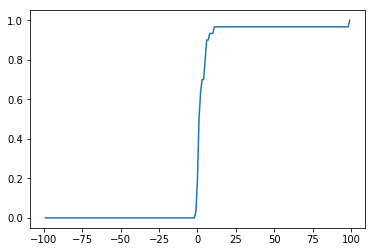

In [151]:
plt.plot(np.arange(-99,100), yard_cdf[98,:])
print(yard_cdf[98,97:103])

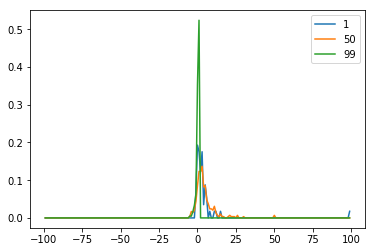

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.00803213
 0.00401606 0.01204819 0.02409639 0.04417671 0.04819277 0.09638554
 0.11646586 0.08032129 0.13253012 0.08835341 0.06425703 0.06827309
 0.0562249  0.04016064 0.02811245 0.00803213 0.01204819 0.01204819
 0.01204819 0.00803213 0.00803213 0.         0.         0.
 0.         0.00401606 0.00401606 0.         0.00401606 0.00401606
 0.         0.00401606 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.00401606 0.         0.
 0.         0.         0.         0.         0.         0.
 0.00401606]


In [125]:
for yard_line in [1,50,99]:
    yard_line_index = yard_line -1
    plt.plot(np.arange(-99,100),yard_probabilities[yard_line_index,:], label = str(yard_line))
    
plt.legend()    
plt.show() 

# Observations: seems like there is some data missing...
# at the 50 yard line, many yards gained in the 0-50 window have 0 probability, 
# even those should have almost certainly happened some! 
# uncomment the line below for an example 
# Is Laplace smoothing the solution? Or something more significant? 
print(yard_probabilities[50, 52:149]) # look at all possible yards gained at the 50 yard line 

In [154]:
all_loss = []
for index, row in dev.iterrows():
    pred_cdf = squash(yard_cdf[int(row['YardsRemaining'])-1,:], int(row['YardsRemaining']))
    true_cdf = np.zeros(199)
    true_cdf[99+row['Yards']:] = 1
    loss = 1/199 * np.sum((pred_cdf-true_cdf)**2)
    all_loss.append(loss)
cost = np.average(all_loss)
print("Cost: {}".format(cost))

Cost: 0.014088655099676866


## Using Kernel methods on model for each yard line

In [172]:
#tune this as needed
sigma = 16
boosted_cdf = np.zeros(199)
weights = []
for true_remaining in range(1,100):
    for model_remaining in range (1,100):
        yard_line_cdf = yard_cdf[model_remaining-1,:]
        weight = np.exp(-((true_remaining - model_remaining)**2) / (2*(sigma**2)))
        weights.append(weight)
        boosted_cdf += weight*yard_line_cdf
        
#normalize the cdf
boosted_cdf = boosted_cdf / np.sum(weights)

       

## Compute loss for weighted model

In [173]:
all_loss = []
for index, row in dev.iterrows():
    pred_cdf = squash(boosted_cdf, int(row['YardsRemaining']))
    true_cdf = np.zeros(199)
    true_cdf[99+row['Yards']:] = 1
    loss = 1/199 * np.sum((pred_cdf-true_cdf)**2)
    all_loss.append(loss)
cost = np.average(all_loss)
print("Cost: {}".format(cost))

Cost: 0.014044888138695224
